# Assignment - 7 Sound Localisation
The following code deals with reconstructing an image using Delay and Sum Algorithm, which is commonly used in ultrasound image reconstruction. A sound source is located at the origin and emits sound waves in the form of Sinc pulses. When these come in contact with an obstacle, they get reflected back to an array of microphones arranged along the y-axis. Each microphone receives the reflected sound waves with a slight delay acccording to its distance from the obstacle. By calculating these delays, we can reconstruct the image with the obstacle's position.

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

In [119]:
def wsrc(t: np.ndarray) -> np.ndarray:
    """
    Creating a sinc pulse.

    Parameters:
    t (np.ndarray) : Time values to evaluate the sinc function at.

    Returns:
    (np.ndarray) The value of sinc at each time instant in the input array.

    """
    return np.sinc(SincP * t)


## Plotting the Sinc Pulse
### Initialising Parameters:
- Number of Microphones `Nmics`: The microphones are placed along the Y-axis, centered at (0, 0).
- Source Location `src`: The coordinates of the Source
- Number of Samples `Nsamp`: Number of samples collected for each microphone.
- Speed of Sound `C`
- Pitch `pitch`: Distance between microphones along the Y-axis.
- Distance per Sample `dist_per_samp`: Spatial interval per sample, that scales all the values.
- Time per Sample `time_per_samp`: The time interval between successive samples.
- Sinc Pulse width scaling factor `SincP`: Scales the width of the sinc pulse.

In [120]:
def plotting(dist_per_samp, C, SincP, Nsamp = 200, Nmics = 64)-> None:
  """
  Plots the sinc pulse for the given parameters.

  Parameters:
  Nmics (int): Number of Microphones
  Nsamp (int): Number of samples
  dist_per_samp (float): Distance per sample
  C (float): Speed of Sound
  SincP (float): Sinc Pulse width scaling factor

  Returns: None
  """
  time_per_samp = dist_per_samp / C # Calculating the time interval between samples
  t = np.linspace(0, (Nsamp // 2) * (time_per_samp), Nsamp // 2) # Creating time points for the positive x axis.

  # Plotting the sinc Pulse
  plt.plot(t, wsrc(t))
  plt.title("Source Sinc Pulse")
  plt.xlabel("Time")
  plt.ylabel("Amplitude")
  plt.show()

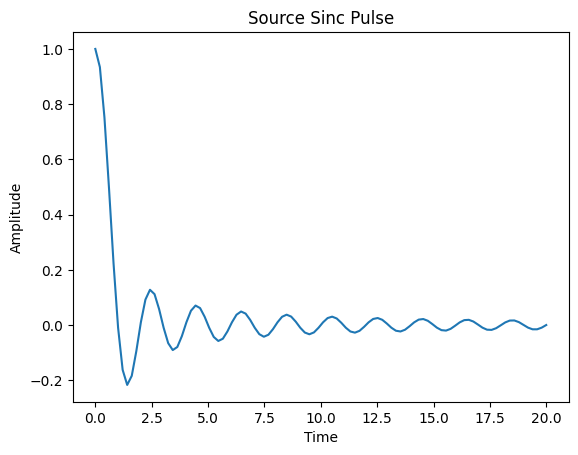

In [121]:
  dist_per_samp = 0.1
  C = 0.5
  SincP = 1
  plotting(dist_per_samp, C, SincP)

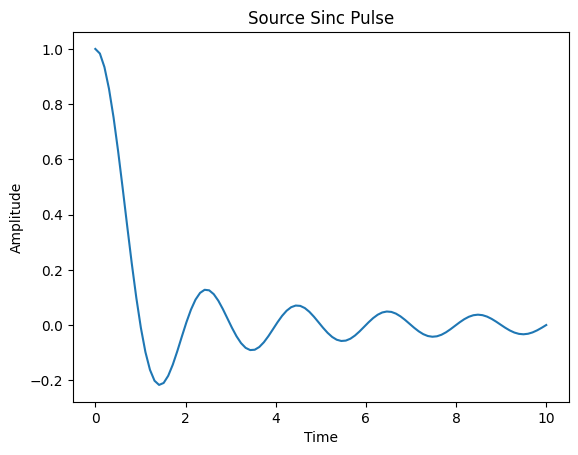

In [122]:
dist_per_samp = 0.05 # keeping Nsamp constant, and reducing the dist_per_samp by 2.
C = 0.5
SincP = 1
plotting(dist_per_samp, C, SincP) # Observe the difference in x-axis values captured.

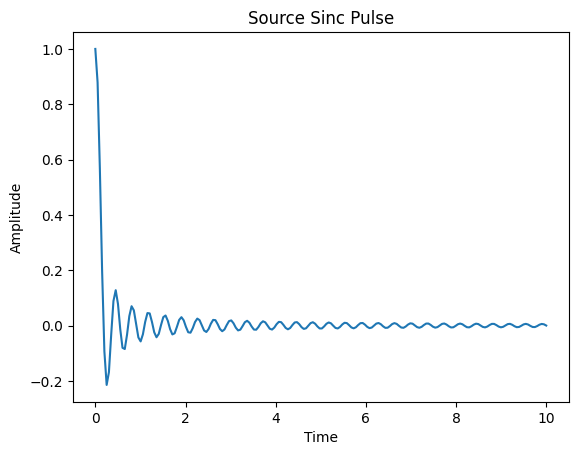

In [123]:
SincP = 5.5 # width of the pulse reduces
Nsamp = 400 # Increased Nsamp resulting in smoother graph
dist_per_samp = 0.025 # Product of Nsamp and dist_per_samp keeps the x-axis values captured same as previous case.
C = 0.5
plotting(dist_per_samp, C, SincP, Nsamp)

In [124]:

def dist(src: Tuple[float, float], pt: Tuple[float, float], mic: Tuple[float, float]) -> float:
    """
    Calculating the total distance traveled by a sound wave from the source to an obstacle and to a microphone.

    Parameters:
    src (Tuple[float, float]) : (x,y) coordinates of the sound source.
    pt (Tuple[float, float]) : (x,y) coordinates of the point in the grid under consideration.
    mic (Tuple[float, float]) : (x,y) coordinates of the microphone receiving the reflected sound wave.

    Returns:
    d1 + d2 (float) : The total distance traveled by the sound wave.

    """
    d1 = np.sqrt((pt[0] - src[0]) ** 2 + (pt[1] - src[1]) ** 2)  # Distance from source to obstacle
    d2 = np.sqrt((mic[0] - pt[0]) ** 2 + (mic[1] - pt[1]) ** 2)  # Distance from obstacle to microphone
    return d1 + d2


In [125]:
def obstacle_locator(filepath: str = None, obstacle: tuple = None, Nmics: int = 64, Nsamp: int = 200,
                     pitch: float = 0.1, dist_per_samp: float = 0.1, C: float = 0.5) -> None:
    """
    Reconstructing an image using the Delay-and-Sum (DAS) algorithm to locate an obstacle
    based on either microphone data from a file or given obstacle location.

    Parameters:
    filepath (str) : optional with Default as None, Path to the text file containing the microphone sample data.
    obstacle (tuple) : optional with Default as None, (x,y) coordinates of the obstacle
    Nmics (int) : optional with default as 64, Number of microphones in the array
    Nsamp (int) : optional with default as 200, number of samples per microphone
    pitch (float) : optional with default as 0.1, distance between adjacent microphones in the y-axis
    dist_per_samp (float) : optional with default as 0.1, distance interval per sample
    C (float) : optional with default as 0.5, speed of sound in the medium

    Returns: None

    """
    src = (0, 0) # coordinates of the source of sound wave
    # Defining microphone positions along the Y-axis
    # Symmetric about origin with each spaced a pitch apart
    mics = []
    for i in range(Nmics):
        mics.append((0, (i - (Nmics + 1) / 2) * pitch))

    # Loading microphone data from the input file, if available
    if filepath:
        data = np.loadtxt(filepath)
    else:
        # If no file is given, we simulate the microphone outputs for the given obstacle
        obstacle = obstacle
        time_per_samp = dist_per_samp / C

        # Creating time points for the x-axis
        t = np.linspace(0, (Nsamp - 1) * time_per_samp, Nsamp)

        # Calculating delayed signals received at each microphone due to reflection from the obstacle
        mic_outputs = []
        for mic in mics:
            total_dist = dist(src, obstacle, mic)  # Total distance to the obstacle from the mic
            delay = int(total_dist / dist_per_samp)  # Delay based on the distance
            mic_output = np.roll(wsrc(t), delay)  # Shifting the pulse according to the delay
            mic_outputs.append(mic_output)
        mic_outputs = np.array(mic_outputs)
        data = mic_outputs  # Assigning the simulated microphone outputs to 'data'

        # Plotting the delayed signals for all microphones as a heatmap
        plt.figure(figsize=(5, 5))
        plt.imshow(mic_outputs, aspect='auto')
        plt.xlabel("Time")
        plt.ylabel("Microphone Index")
        plt.title("Delayed Signals from All Microphones")
        plt.show()

    # Initialize the grid for the DAS algorithm
    grid_x = np.linspace(0, dist_per_samp * (Nsamp - 1), Nsamp)
    grid_y = np.linspace(-Nmics * pitch / 2, Nmics * pitch / 2, Nmics)
    image = np.zeros((len(grid_x), len(grid_y)))  # Empty grid for the image

    # Delay-and-Sum Algorithm
    for i, gx in enumerate(grid_x):
        for j, gy in enumerate(grid_y):
            pt = (gx, gy)  # Current grid point
            signal_sum = 0  # Initialising the signal sum for a point as 0

            # Iterating over microphones to calculate each of their contribution to a point
            for mic_idx, mic in enumerate(mics):
                total_dist = dist(src, pt, mic)  # Distance from current point to the mic
                delay = int(total_dist / dist_per_samp)  # Converting distance to delay

                # Adding the signal if the delay is within sample range
                if 0 <= delay < Nsamp:
                    signal_sum += data[mic_idx, delay]

            # Storing the net signal strength in the image grid
            image[i, j] = signal_sum

    # Plot the reconstructed image as indices in the defined grid
    plt.figure(figsize=(5, 5))
    plt.imshow(image.T)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(f"Reconstructed Image: Nmics = {Nmics} | Nsamp = {Nsamp}")
    plt.show()

    # Plot the reconstructed image with the physical coordinate system
    plt.imshow(image.T, extent=[grid_x.min(), grid_x.max(), grid_y.max(), grid_y.min()], aspect='auto')
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Reconstructed Image: Actual Coordinate System")
    plt.show()


## For given obstacle location (3,-1), we are plotting the following
- Delayed signals for all the microphones after reflection from the obstacle.
- Reconstructed image in terms of the indices defined for the image.
- Reconstructed image in terms of the physical coordinates.

When these are plotted for two different C values: 0.5 and 2, we can observe that as C is reduced from 2 to 0.5, the final image becomes more sharp, increasing the accuracy of finding the obstacle location.

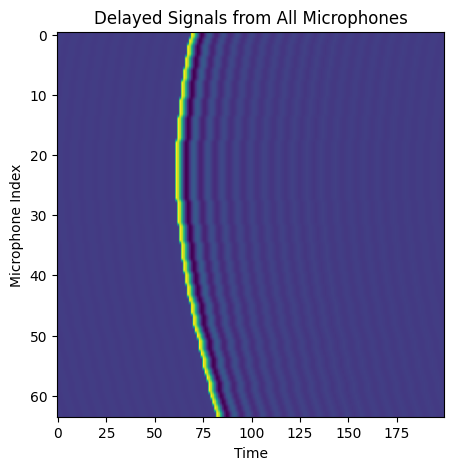

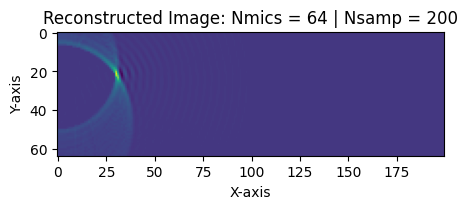

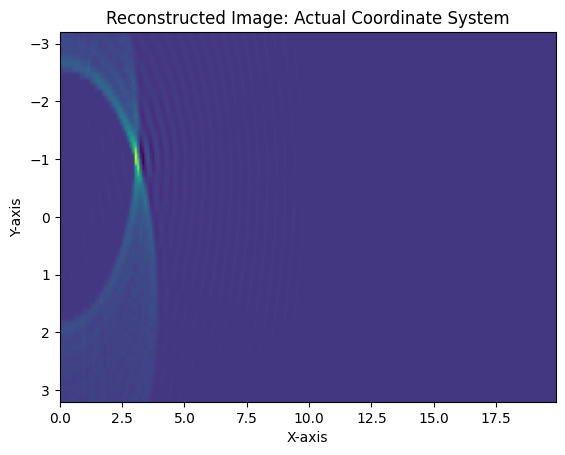

In [126]:
obstacle_locator(None, (3,-1), C = 2.0)

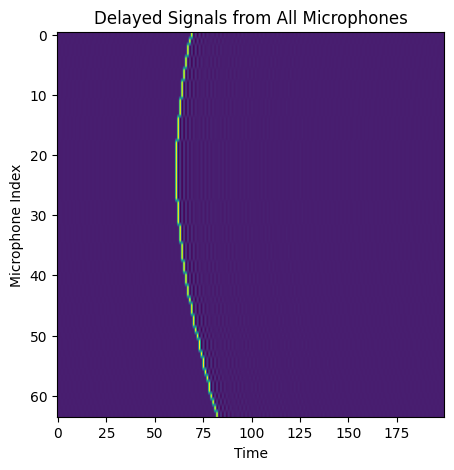

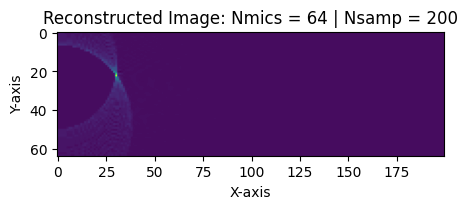

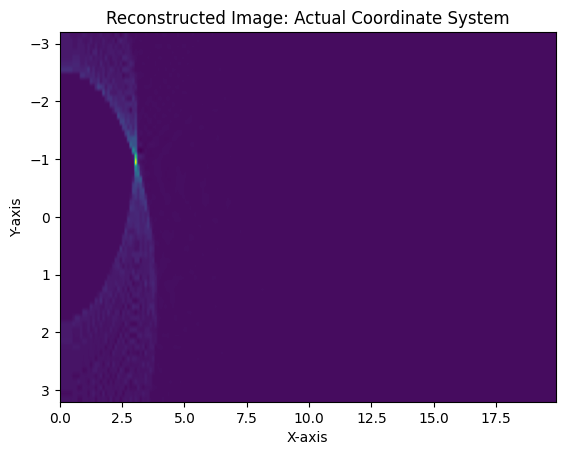

In [127]:
obstacle_locator(None, (3,-1), C = 0.5)

## Visualising the plots for rx2.txt
Update the below function call with appropriate file path of `rx2.txt`

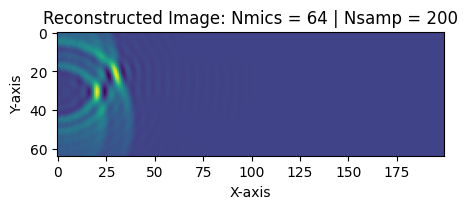

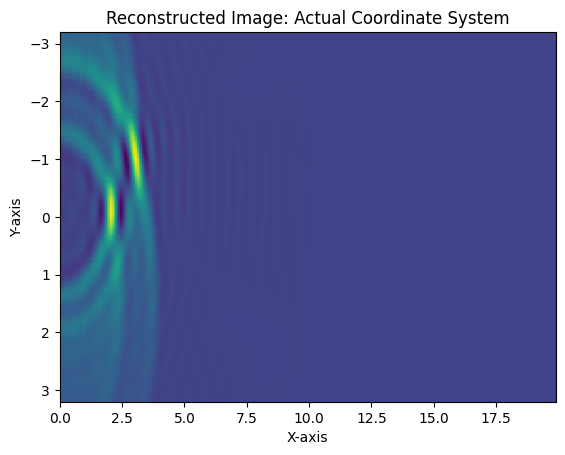

In [128]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 64, Nsamp = 200)

## Visualising the plots for rx3.txt
Update the below function call with appropriate file path of `rx3.txt`

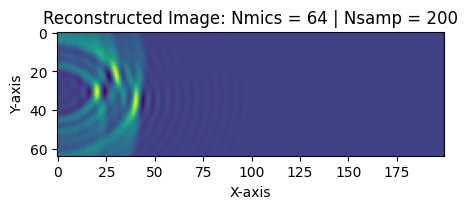

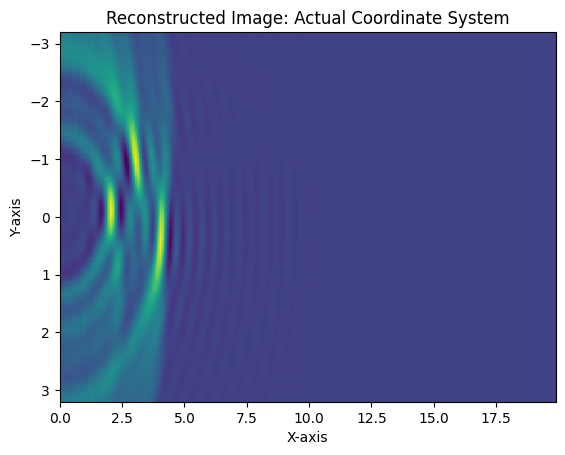

In [129]:
obstacle_locator('/content/sample_data/rx3.txt', Nmics = 64, Nsamp = 200)

## Experimenting with Nmic = [8, 32, 64] and Nsamp = [50, 100, 200] for rx2.txt

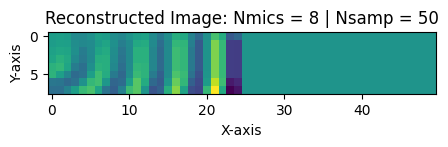

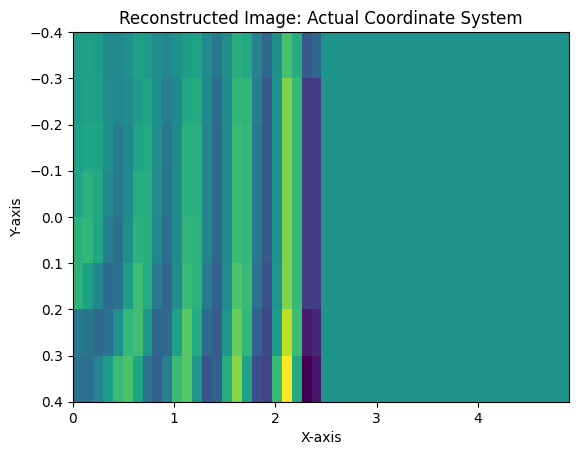

In [130]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 8, Nsamp = 50)

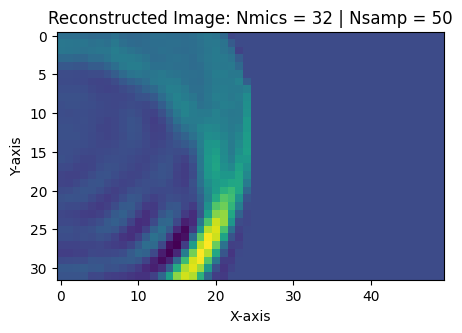

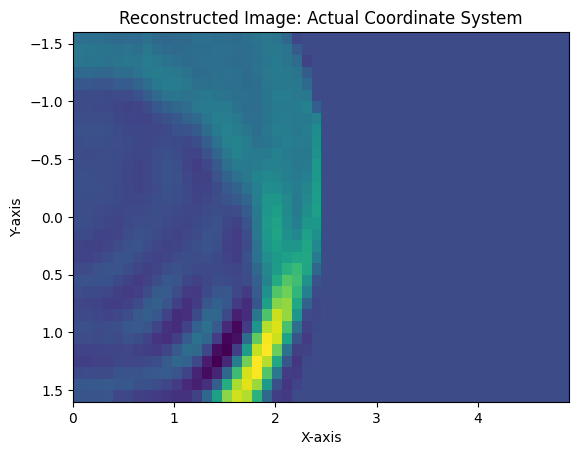

In [131]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 32, Nsamp = 50)

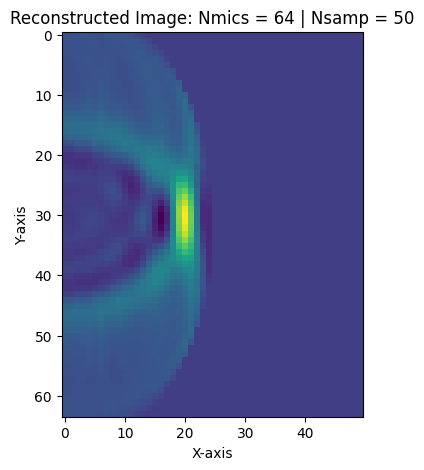

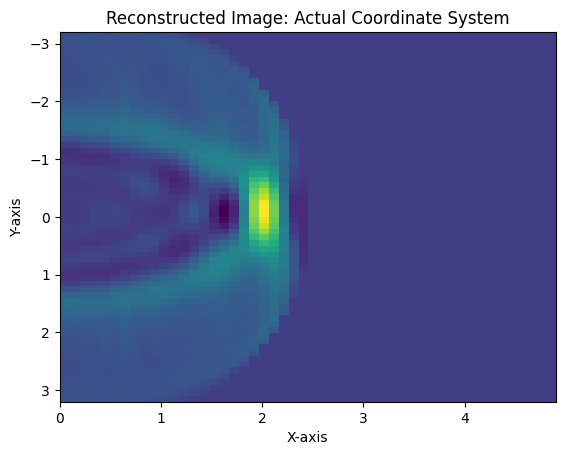

In [132]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 64, Nsamp = 50)

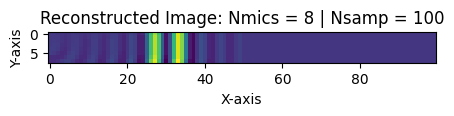

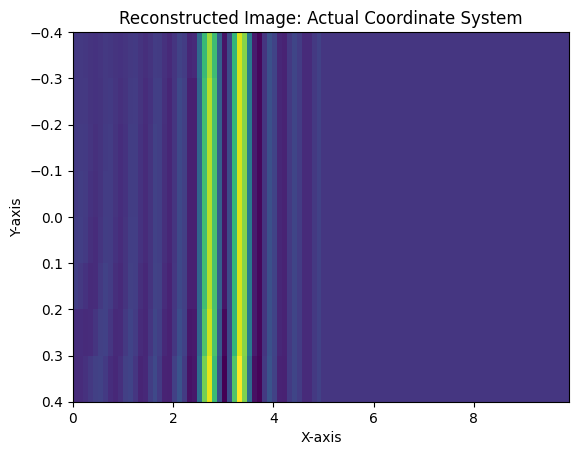

In [133]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 8, Nsamp = 100)

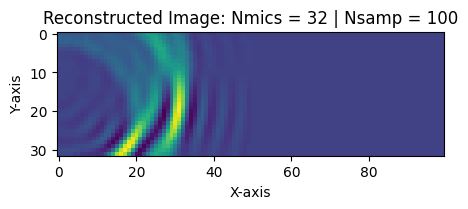

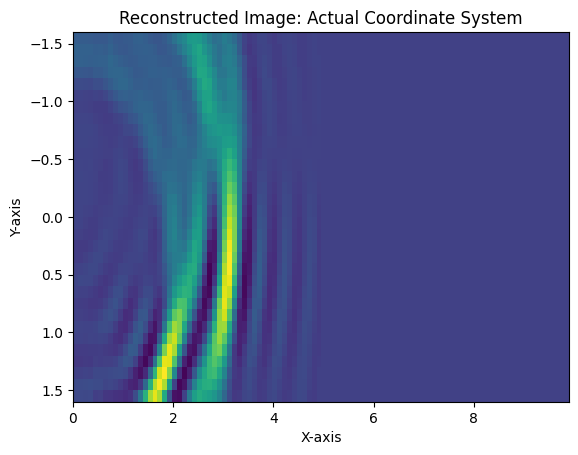

In [134]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 32, Nsamp = 100)

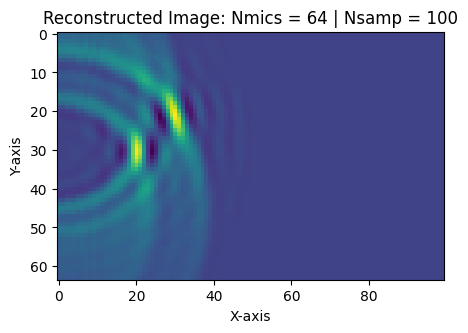

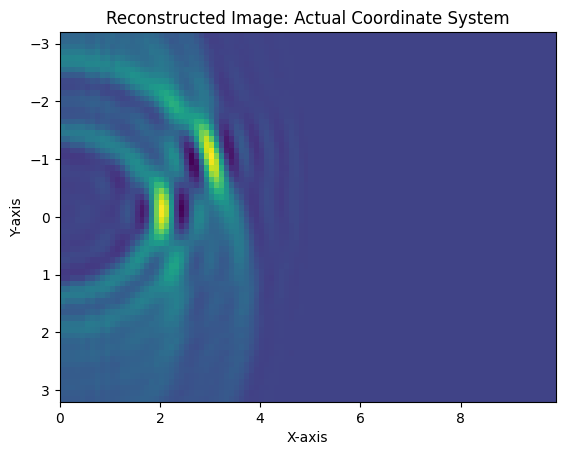

In [135]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 64, Nsamp = 100)

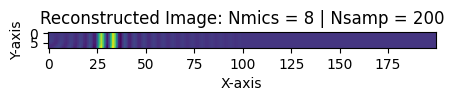

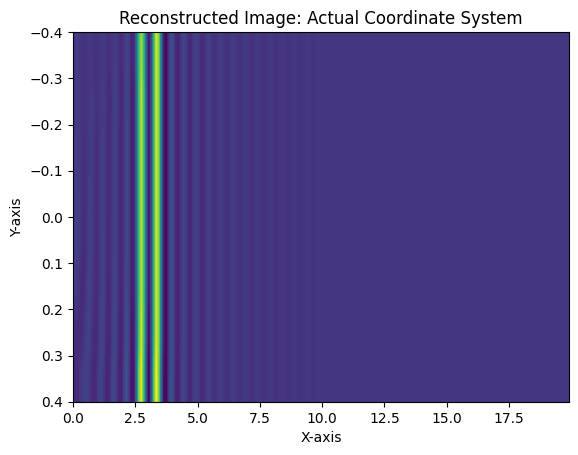

In [136]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 8, Nsamp = 200)

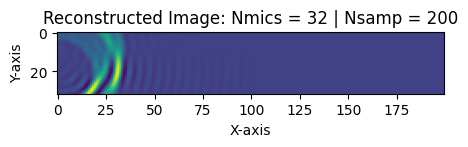

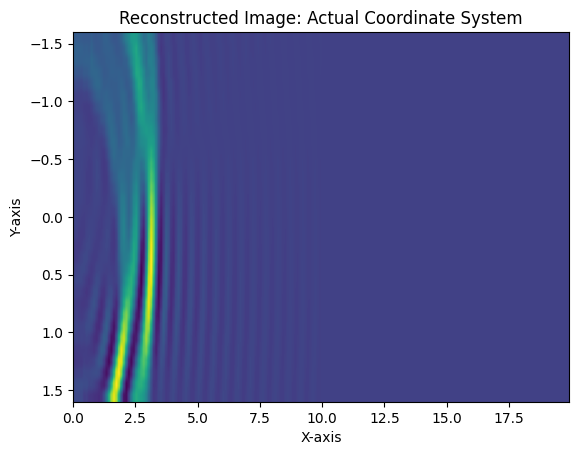

In [137]:
obstacle_locator('/content/sample_data/rx2.txt', Nmics = 32, Nsamp = 200)